In [1]:
import Tiled_Classification_RF as TCRF
import os, tempfile
from osgeo import gdal, ogr, gdal_array # I/O image data
import numpy as np # math and array handling
import matplotlib.pyplot as plt # plot figures
from sklearn.ensemble import RandomForestClassifier # classifier
import pandas as pd # handling large data as table sheets
import geopandas as gpd # handling large data as shapefiles
from sklearn.metrics import classification_report, accuracy_score,confusion_matrix  # calculating measures for accuracy assessment
import datetime
from xgboost import XGBClassifier
# Tell GDAL to throw Python exceptions, and register all drivers
gdal.UseExceptions()
gdal.AllRegister()
from GIStools.GIStools import preprocess_SfM_inputs
from GIStools.Stitch_Rasters import stitch_rasters
from GIStools.Grid_Creation import create_grid
from GIStools.Raster_Matching import pad_rasters_to_largest
from Archive.RF_driver_parameters import InputParameters
import joblib

In [2]:
#-------------------Required User Defined Inputs-------------------#
params = InputParameters()

DEM_path = params.DEM_path
ortho_path = params.ortho_path
output_folder = params.output_folder
model_path = params.model_path
training_path = params.training_path
validation_path = params.validation_path
attribute = params.attribute
validation_path_2 = params.validation_path_2
grid_ids_to_process = params.grid_ids_to_process
grid_path = params.grid_path
process_training_only = params.process_training_only
est = params.est
n_cores = params.n_cores
gradient_boosting = params.gradient_boosting
verbose = params.verbose
stitch = params.stitch

#--------------------Input Preparation-----------------------------#
#Create output folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder) 

#List of grid-clipped images to classify and associated id values
in_dir = os.path.join(output_folder, 'RF_Tiled_Inputs')
#output folder for list of img_path_list grid-clipped classified images

# directory, where the classification image should be saved:
results_folder = os.path.join(output_folder, 'RF_Results')
if not os.path.exists(results_folder):
    os.makedirs(results_folder)
classification_image = os.path.join(results_folder, 'Classified_Training_Image.tif')
classified_tile_folder = os.path.join(results_folder, 'Classified_Tiles')
if not os.path.exists(classified_tile_folder) and process_training_only == False:
    os.makedirs(os.path.join(classified_tile_folder))

In [3]:
#==================== Preprocessing ====================#
    #Create grid cells to process large rasters in chunks. 
#Each grid cell is the size of the extent training and validation shapefiles
if grid_path is None:
    train_val_grid_id, grid_path, _ = create_grid([training_path,validation_path], DEM_path, in_dir)
    if process_training_only: #preprocess_function will now only process the training tile
        grid_ids_to_process.append(train_val_grid_id)

    print('Training Grid ID: {}'.format(train_val_grid_id)) 
else:
    grid = gpd.read_file(grid_path)
    grid_ids_to_process = grid['ID'].values.tolist()
    print('Grid IDs: {}'.format(grid_ids_to_process))  
#Bands output from preprocess function: Roughness, R, G, B, Saturation, Excessive Green Index
grid_ids_to_process, _ = preprocess_SfM_inputs(grid_path, ortho_path, DEM_path, grid_ids_to_process, in_dir, verbose=verbose) #Prepare input stacked rasters for random forest classification
print('Grid IDs to process: {}'.format(grid_ids_to_process))
#Ensure all rasters are the same size by padding smaller rasters with 0s. Having raster tiles of identical sizes is required for random forest classification
raster_dims = pad_rasters_to_largest(in_dir, verbose=verbose)
img_path_list, id_values = TCRF.find_files(in_dir) # list of all grid-clipped images to classify and associated id values
attribute_names = TCRF.print_attributes(training_path) # print the attributes in the training shapefile


Training Grid ID: 29
Processing grid cell 1 of 1
Grid IDs to process: [29]
Less than two rasters in folder. Skipping padding.
Available attributes in the shape file are: ['id', 'Cover_Type', 'XGB']


Extracting image data from: Y:\ATD\GIS\East_Troublesome\RF Vegetation Filtering\LM2\LM2_2023___081222 - XGB Saved Model\RF_Tiled_Inputs\stacked_bands_tile_input_29.tif
Image extent: 5142 x 9238 (row x col)
Number of Bands: 6
Unique labels values: [1 2 3 4 5]
Unique y values: [1 2 3 4 5]
Reshaped from (5142, 9238, 6) to (47501796, 6)
No slicing was necessary!
Reshaped back to (5142, 9238)
Image saved to: Y:\ATD\GIS\East_Troublesome\RF Vegetation Filtering\LM2\LM2_2023___081222 - XGB Saved Model\RF_Results\Classified_Training_Image.tif
Unique labels values: [1 2 3 4 5]
Unique y values: [1 2 3 4 5]
83081 validation pixels
validation data include 5 classes: [1 2 3 4 5]
Our X matrix is sized: (83081,)
Our y array is sized: (83081,)
col_0      0     1     2      3     4    All
row_0                                       
0      15487  2754  1153    940   294  20628
1          5  3251   130    134   249   3769
2          0  1410  1611     35    25   3081
3         11  1566    89  52134   143 

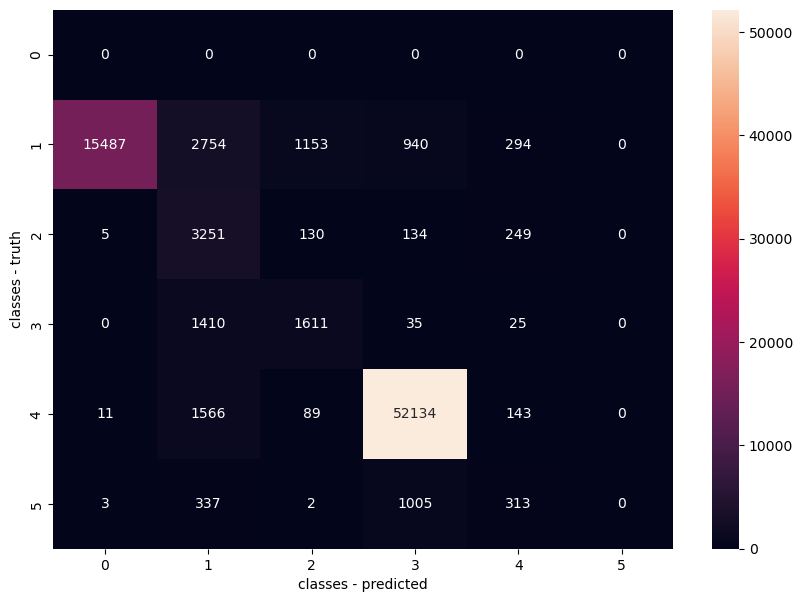

In [4]:

#===========================Main Classification Loop===========================#
train_tile_path = os.path.join(in_dir, f'stacked_bands_tile_input_{train_val_grid_id}.tif') # grid-clipped-image containing the training data
results_txt = os.path.join(output_folder, 'Results_Summary.txt') # directory, where the all meta results will be saved
TCRF.print_header(results_txt, DEM_path, ortho_path, train_tile_path, training_path, validation_path, img_path_list, attribute) # print the header for the results text file
train_tile, train_tile_3Darray = TCRF.extract_image_data(train_tile_path, results_txt, est, log=True) # extract the training tile image data
# Extract training data from shapefile
X_train, y_train, labels, roi = TCRF.extract_shapefile_data(training_path, train_tile, train_tile_3Darray, results_txt, attribute, "TRAINING")
#add 0 onto front of y-train and labels to account for 0 values in the classification
if model_path == None:
    rf, rf2 = TCRF.train_RF(X_train, y_train, train_tile, results_txt, output_folder, est, n_cores, 
                            gradient_boosting = gradient_boosting, verbose = verbose) # train the random forest classifier
else:
    rf = joblib.load(model_path)  # Load the saved model

train_tile_2Darray = TCRF.flatten_raster_bands(train_tile_3Darray) # Convert NaNs to 0.0
class_prediction = TCRF.predict_classification(rf, train_tile_2Darray, train_tile_3Darray) # predict the classification for each pixel using the trained model
masked_prediction = TCRF.reshape_and_mask_prediction(class_prediction, train_tile_3Darray) # mask the prediction to only include bare earth and vegetation
TCRF.save_classification_image(classification_image, train_tile, train_tile_3Darray, masked_prediction) # save the masked classification image
# Extract validation data from shapefile
X_v, y_v, labels_v, roi_v = TCRF.extract_shapefile_data(validation_path, train_tile, class_prediction, results_txt, attribute, "VALIDATION") 
TCRF.model_evaluation(X_v, y_v, labels_v, roi_v, class_prediction, 
                      results_txt, gradient_boosting=gradient_boosting) # evaluate the model using the validation data

del train_tile # close the image dataset

In [5]:
print(train_tile_3Darray.shape)
print(train_tile_2Darray.shape)
print(X_v.shape)
print(y_v.shape)

#get rows and cols from train tile path
#open train tile path
train_tile = gdal.Open(train_tile_path)
rows = train_tile.RasterYSize
cols = train_tile.RasterXSize
bands = train_tile.RasterCount
print(f"Rows: {rows}, Cols: {cols}, Bands: {bands}")
print(f"Class prediction shape: {class_prediction.shape}")

(5142, 9238, 6)
(47501796, 6)
(83081,)
(83081,)
Rows: 5142, Cols: 9238, Bands: 6
Class prediction shape: (5142, 9238)


In [ ]:

#gwet dimensions and resolution for 
